In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 1000

import geopandas as gpd
from shapely.geometry import Point, Polygon

## EDA

### sample 200 in each year / station

### seasonal trend

### coefficient




/Users/rainylty/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/rainylty/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


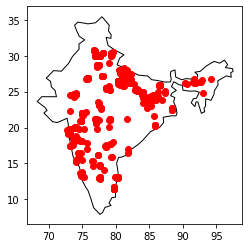

In [9]:
# read and plot station 

stations = pd.read_csv('../../data/STATION.csv')
stations['geometry'] = stations.apply(lambda x: Point((float(x['Lon']), float(x['Lat']))), axis=1)
stations = gpd.GeoDataFrame(stations, geometry='geometry')
stations.crs = {'init': 'epsg:4326'}

# show plot with india map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'India'].plot(color='white', edgecolor='black')
stations.plot(ax=ax, color='red')
plt.show()



In [85]:
# sample 15 stations, and plot them with station id and name, make them interactive

import folium

m = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for i in range(5):
	folium.Marker([stations.iloc[i]['Lat'], stations.iloc[i]['Lon']],
	              popup=stations.iloc[i]['station_id']).add_to(m)

# 
# m.save('../../data/stations.html')

m

In [77]:
# input dir
input_dir = '../../data/yearly_climate_by_station/1'

# read all files into one df

import os

files = os.listdir(input_dir)
df = pd.DataFrame()
for file in files:
	df = pd.concat([df, pd.read_csv(os.path.join(input_dir, file))])

# df.head()

# drop column: From date, To date, ESMI_ID

df.drop(['From date', 'To date', 'ESMI_ID'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       52584 non-null  int64  
 1   Location name    52584 non-null  object 
 2   District         52584 non-null  object 
 3   State            52584 non-null  object 
 4   Category         52584 non-null  object 
 5   Connection Type  52584 non-null  object 
 6   Lat              52584 non-null  float64
 7   Lon              52584 non-null  float64
 8   t2m              52584 non-null  float64
 9   u10              52584 non-null  float64
 10  v10              52584 non-null  float64
 11  tp               52584 non-null  float64
 12  date             52584 non-null  int64  
 13  time             52584 non-null  int64  
dtypes: float64(6), int64(3), object(5)
memory usage: 6.0+ MB


In [80]:
# Convert 'date' to a string and 'time' from int64 to a string, ensuring proper formatting
df['date'] = df['date'].astype(str)
# Convert 'time' to string and pad with zeros if necessary
df['time'] = df['time'].astype(str).apply(lambda x: x.zfill(4))

# Combine 'date' and 'time' columns and convert to datetime
df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M')

# Display the result
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52584 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       52584 non-null  int64         
 1   Location name    52584 non-null  object        
 2   District         52584 non-null  object        
 3   State            52584 non-null  object        
 4   Category         52584 non-null  object        
 5   Connection Type  52584 non-null  object        
 6   Lat              52584 non-null  float64       
 7   Lon              52584 non-null  float64       
 8   t2m              52584 non-null  float64       
 9   u10              52584 non-null  float64       
 10  v10              52584 non-null  float64       
 11  tp               52584 non-null  float64       
 12  date             52584 non-null  object        
 13  time             52584 non-null  object        
 14  datetime         52584 non-null  dateti

In [74]:

df['date'] = df['date'].astype(str)
# Convert 'time' to string and pad with zeros if necessary
df['time'] = df['time'].astype(str).apply(lambda x: x.zfill(4))

# Combine 'date' and 'time' columns and convert to datetime
df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M')

df.info()

KeyError: 'date'

In [81]:
df.set_index('datetime', inplace=True)


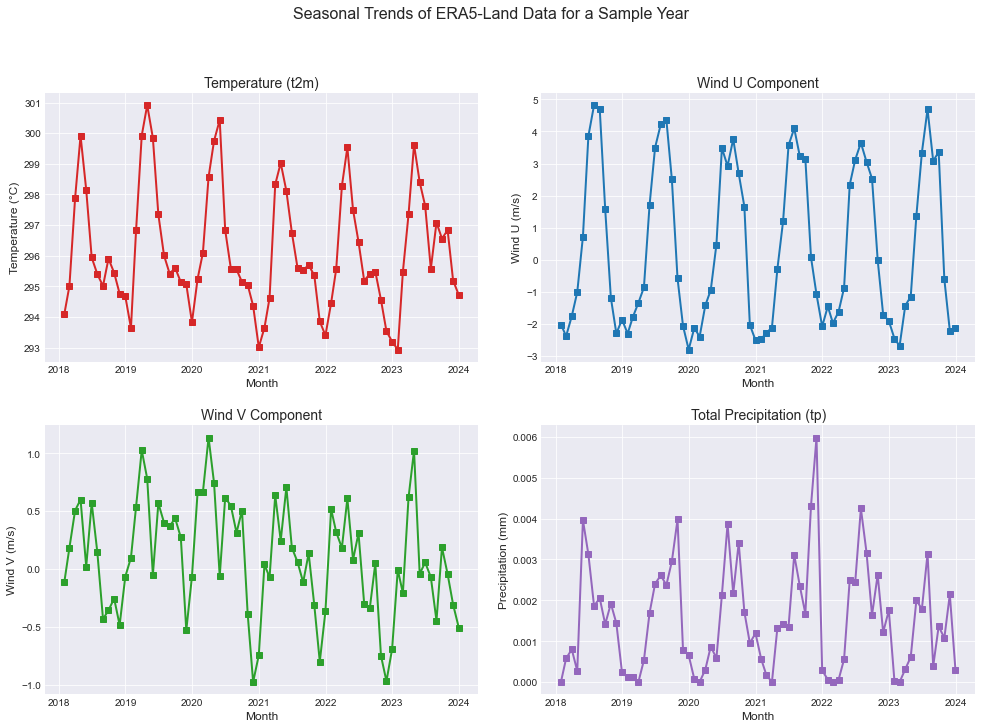

In [82]:
# Resample data to monthly means to observe seasonal trends
df_monthly = df.resample('M').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Seasonal Trends of ERA5-Land Data for a Sample Year',
             fontsize=16, y=1.02)

# Temperature (t2m)
axes[0, 0].plot(df_monthly.index, df_monthly['t2m'], marker='s',
                color='tab:red', linewidth=2, markersize=6)
axes[0, 0].set_title('Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Wind component (u10)
axes[0, 1].plot(df_monthly.index, df_monthly['u10'],
                marker='s', color='tab:blue', linewidth=2, markersize=6)
axes[0, 1].set_title('Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Wind component (v10)
axes[1, 0].plot(df_monthly.index, df_monthly['v10'],
                marker='s', color='tab:green', linewidth=2, markersize=6)
axes[1, 0].set_title('Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Total Precipitation (tp)
axes[1, 1].plot(df_monthly.index, df_monthly['tp'], marker='s',
                color='tab:purple', linewidth=2, markersize=6)
axes[1, 1].set_title('Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label
for ax in axes.flat:
    ax.set_xlabel('Month', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

# plt.savefig('../../data/seasonal_trends.png', dpi=300)

Note: Plotting the 1,424 ids may result in messy charts and never-ending facetgrids that take for ever to load. Best to sample a few ids used consistently throughout the notebook, and run the analyses for a few samples before making final conclusions.

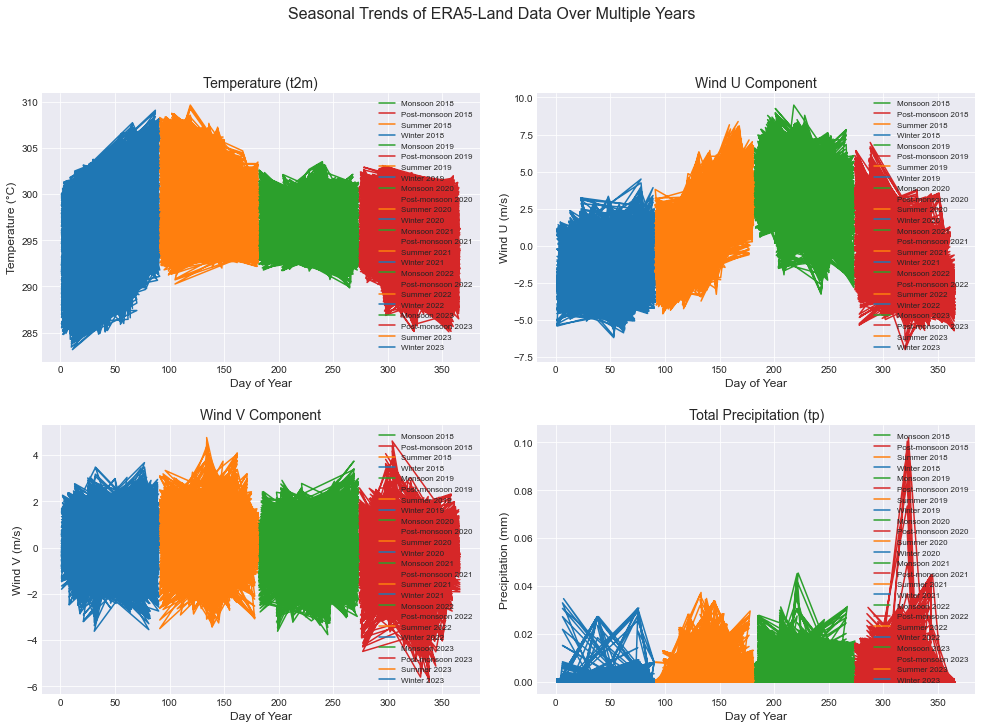

<Figure size 432x288 with 0 Axes>

In [87]:


# Extract the year and month for season identification
df['year'] = df.index.year
df['month'] = df.index.month

# Define seasons based on month


def get_season(month):
    # spring 3-5, summer 6-8, monsoon 9-11, winter 12-2
    if month in [1, 2, 3]:
        return 'Winter'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Monsoon'
    else:
        return 'Post-monsoon'


df['season'] = df['month'].apply(get_season)

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Seasonal Trends of ERA5-Land Data Over Multiple Years', fontsize=16, y=1.02)

# Define colors for each season
season_colors = {'Winter': 'tab:blue', 'Summer': 'tab:orange',
                 'Monsoon': 'tab:green', 'Post-monsoon': 'tab:red'}

# Function to plot data for each variable by season


def plot_seasonal_trend(ax, variable, title, ylabel):
    for year, group in df.groupby('year'):
        for season, season_group in group.groupby('season'):
            ax.plot(season_group.index.dayofyear, season_group[variable],
                    color=season_colors[season], label=f'{season} {year}' if year == group['year'].min() else "")

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True)


# Plot seasonal trends for each variable
plot_seasonal_trend(axes[0, 0], 't2m', 'Temperature (t2m)', 'Temperature (°C)')
plot_seasonal_trend(axes[0, 1], 'u10', 'Wind U Component', 'Wind U (m/s)')
plot_seasonal_trend(axes[1, 0], 'v10', 'Wind V Component', 'Wind V (m/s)')
plot_seasonal_trend(
    axes[1, 1], 'tp', 'Total Precipitation (tp)', 'Precipitation (mm)')

# Add a shared x-label (Day of Year)
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

# save plot

plt.savefig('../../data/seasonal_trends_multiple_years_stack.png', dpi=300)

In [68]:

plt.savefig('../../data/seasonal_trends_multiple_years.png', dpi=300)

<Figure size 432x288 with 0 Axes>

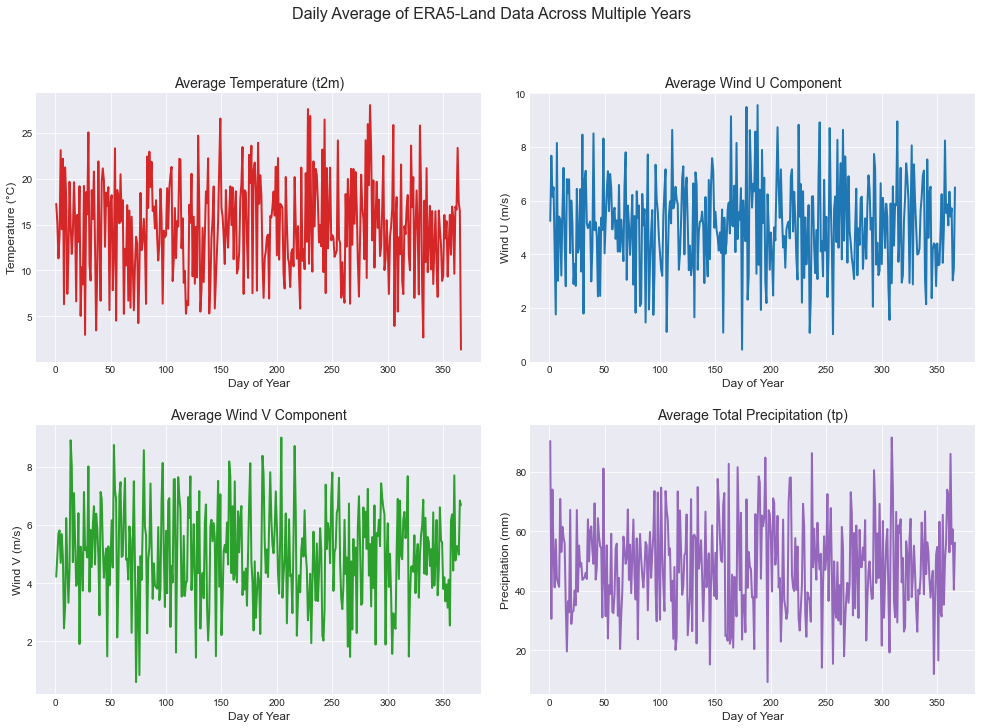

In [71]:


# Extract the day of year for each row
df['day_of_year'] = df.index.dayofyear

# Group by day_of_year and calculate the average for each variable across all years
df_daily_avg = df.groupby('day_of_year').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Daily Average of ERA5-Land Data Across Multiple Years', fontsize=16, y=1.02)

# Plot average t2m
axes[0, 0].plot(df_daily_avg.index, df_daily_avg['t2m'],
                color='tab:red', linewidth=2)
axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Plot average u10
axes[0, 1].plot(df_daily_avg.index, df_daily_avg['u10'],
                color='tab:blue', linewidth=2)
axes[0, 1].set_title('Average Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Plot average v10
axes[1, 0].plot(df_daily_avg.index, df_daily_avg['v10'],
                color='tab:green', linewidth=2)
axes[1, 0].set_title('Average Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Plot average total precipitation (tp)
axes[1, 1].plot(df_daily_avg.index, df_daily_avg['tp'],
                color='tab:purple', linewidth=2)
axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()

plt.savefig('../../data/daily_avg_multiple_years.png', dpi=300)

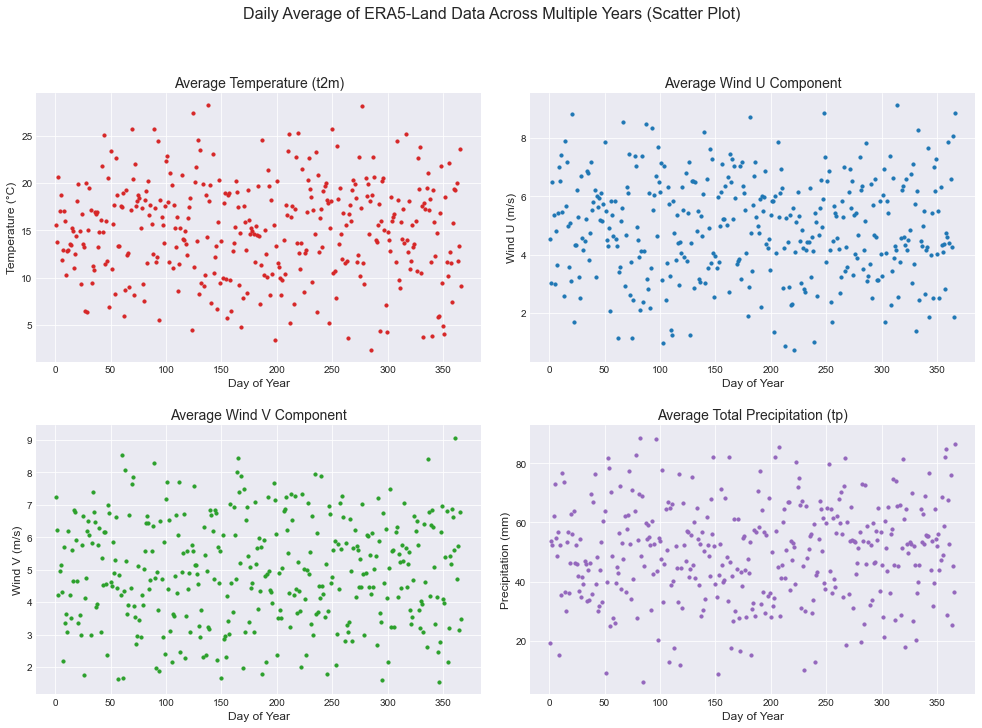

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace with your actual data)
data = {
    # 3 years of daily data
    'datetime': pd.date_range(start='2020-01-01', periods=1095, freq='D'),
    't2m': np.random.rand(1095) * 30,  # Simulated temperature values
    'wind_u': np.random.rand(1095) * 10,  # Simulated wind_u values
    'wind_v': np.random.rand(1095) * 10,  # Simulated wind_v values
    'tp': np.random.rand(1095) * 100,  # Simulated precipitation values
}
df = pd.DataFrame(data)

# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Extract the day of year for each row
df['day_of_year'] = df.index.dayofyear

# Group by day_of_year and calculate the average for each variable across all years
df_daily_avg = df.groupby('day_of_year').mean()

# Set up plot aesthetics
plt.style.use('seaborn-darkgrid')  # Use a clean grid style

# Create figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    'Daily Average of ERA5-Land Data Across Multiple Years (Scatter Plot)', fontsize=16, y=1.02)

# Scatter plot for average t2m
axes[0, 0].scatter(df_daily_avg.index, df_daily_avg['t2m'],
                   color='tab:red', s=10)
axes[0, 0].set_title('Average Temperature (t2m)', fontsize=14)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0, 0].grid(True)

# Scatter plot for average wind_u
axes[0, 1].scatter(df_daily_avg.index,
                   df_daily_avg['wind_u'], color='tab:blue', s=10)
axes[0, 1].set_title('Average Wind U Component', fontsize=14)
axes[0, 1].set_ylabel('Wind U (m/s)', fontsize=12)
axes[0, 1].grid(True)

# Scatter plot for average wind_v
axes[1, 0].scatter(df_daily_avg.index, df_daily_avg['wind_v'],
                   color='tab:green', s=10)
axes[1, 0].set_title('Average Wind V Component', fontsize=14)
axes[1, 0].set_ylabel('Wind V (m/s)', fontsize=12)
axes[1, 0].grid(True)

# Scatter plot for average total precipitation (tp)
axes[1, 1].scatter(df_daily_avg.index, df_daily_avg['tp'],
                   color='tab:purple', s=10)
axes[1, 1].set_title('Average Total Precipitation (tp)', fontsize=14)
axes[1, 1].set_ylabel('Precipitation (mm)', fontsize=12)
axes[1, 1].grid(True)

# Add a shared x-label (Day of Year)
for ax in axes.flat:
    ax.set_xlabel('Day of Year', fontsize=12)

# Auto-adjust layout
plt.tight_layout(pad=2)

# Show plot
plt.show()